In [1]:
import pandas as pd
df = pd.read_csv('sevennet_slopes.csv')

df.loc[df['v1_Li_slope'] <= 0, 'v1_Li_slope'] = 1e-15

In [2]:
import torch

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

In [3]:
# from ase.md.nvtberendsen import NVTBerendsen
# from sevenn.sevennet_calculator import SevenNetCalculator
# import ase

# filename = '/mnt/hdd/maevskiy/MLIAP-MD-data/gpu_prod/mp-973966-T1000/md.traj'
# atom = ase.io.read(filename)
# calc = SevenNetCalculator('7net-0', device='cpu')
# atom.calc = calc

# atom.get_forces().shape

In [4]:
import torch
# default_dtype = torch.float64
# torch.set_default_dtype(default_dtype)

In [5]:
import os
import ase.io
from sevenn.train.dataload import atoms_to_graph
import numpy as np
from sevenn.sevennet_calculator import SevenNetCalculator
from e3nn.o3 import Irreps, Linear
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sevenn.atom_graph_data import AtomGraphData
from ase.neighborlist import primitive_neighbor_list
import torch

folder_name = '/mnt/hdd/maevskiy/MLIAP-MD-data/gpu_prod/'

temprature = 1000

mean = 0.0    
noise = 0.01  

radial_cutoff = 5

number_noise_samples = 1

dataset = []

for file_name in tqdm(os.listdir(folder_name)):
    forces_noise_samples = []
    material_id = '-'.join(file_name.split('-')[:2])
    if material_id == 'mp-1104241':
        continue
    if f'T1000' in file_name:
        for _ in range(number_noise_samples):
            material_id = '-'.join(file_name.split('-')[:2])
            atoms = ase.io.read(os.path.join(folder_name, file_name, 'md.traj'), index = 0)
            calc = SevenNetCalculator('7net-0', device='cpu')
            atoms.calc = calc
            positions = atoms.get_positions() 
            atoms.set_positions(positions + noise)

            force = atoms.get_forces(apply_constraint=False)
            # pos = atoms.get_positions()
            # cell = np.array(atoms.get_cell())

            edge_src, edge_dst, edge_shift = ase.neighborlist.neighbor_list("ijS", a=atoms, cutoff=radial_cutoff, self_interaction=True)
  
            # edge_src, edge_dst, edge_vec, shifts = primitive_neighbor_list(
            #     'ijDS', atoms.get_pbc(), cell, pos, cutoff = 5, self_interaction=True
            # )
            # is_zero_idx = np.all(edge_vec == 0, axis=1)
            # is_self_idx = edge_src == edge_dst
            # non_trivials = ~(is_zero_idx & is_self_idx)
            # cell_shift = np.array(shifts[non_trivials])

            # edge_vec = edge_vec[non_trivials]
            # edge_src = edge_src[non_trivials]
            # edge_dst = edge_dst[non_trivials]
            # edge_idx = np.array([edge_src, edge_dst])
            log_diffusion = np.log10(df[(df['mpid'] == material_id) & (df['temperature'] == 1000)]['v1_Li_slope'].iloc[0])

            data = Data(
                pos=torch.tensor(atoms.get_positions(), dtype=torch.float32),
                x=torch.tensor(force),
                lattice=torch.tensor(atoms.cell.array, dtype=torch.float32).unsqueeze(0),  # We add a dimension for batching
                edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
                edge_shift=torch.tensor(edge_shift, dtype=torch.float32),
                target = torch.tensor(log_diffusion, dtype=torch.float32)
            )

            dataset.append(data)
    if len(dataset) == 4: 
        break

  5%|▌         | 21/420 [00:09<02:58,  2.23it/s]


In [6]:
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size)

In [7]:
from simple_network.gate_points_networks import SimpleNetwork
from typing import Dict, Union
import torch_scatter

class SimplePeriodicNetwork(SimpleNetwork):
    def __init__(self, **kwargs) -> None:
        """The keyword `pool_nodes` is used by SimpleNetwork to determine
        whether we sum over all atom contributions per example. In this example,
        we want use a mean operations instead, so we will override this behavior.
        """
        self.pool = False
        if kwargs['pool_nodes'] == True:
            kwargs['pool_nodes'] = False
            kwargs['num_nodes'] = 1.
            self.pool = True
        else:
            kwargs['num_nodes'] = 1.
        super().__init__(**kwargs)

    # Overwriting preprocess method of SimpleNetwork to adapt for periodic boundary data
    def preprocess(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        edge_src = data['edge_index'][0]  # Edge source
        edge_dst = data['edge_index'][1]  # Edge destination

        # We need to compute this in the computation graph to backprop to positions
        # We are computing the relative distances + unit cell shifts from periodic boundaries
        edge_batch = batch[edge_src]
        edge_vec = (data['pos'][edge_dst]
                    - data['pos'][edge_src]
                    + torch.einsum('ni,nij->nj', data['edge_shift'], data['lattice'][edge_batch]))

        return batch, data['x'], edge_src, edge_dst, edge_vec

    def forward(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        # if pool_nodes was set to True, use scatter_mean to aggregate
        output = super().forward(data)
        if self.pool == True:
            return torch_scatter.scatter_mean(output, data.batch, dim=0)  # Take mean over atoms per example
        else:
            return output


In [8]:
radial_cutoff = 5

net = SimplePeriodicNetwork(
    irreps_in="1x1o",  
    irreps_out="1x0e",  # Single scalar (L=0 and even parity) to output (for example) energy
    max_radius=radial_cutoff, # Cutoff radius for convolution
    num_neighbors=10.0,  # scaling factor based on the typical number of neighbors
    pool_nodes=True,  # We pool nodes to predict total energy
)

instructions [(0, 0, 1, 'uvu', True), (0, 1, 0, 'uvu', True), (0, 1, 3, 'uvu', True), (0, 1, 5, 'uvu', True), (0, 2, 2, 'uvu', True), (0, 2, 4, 'uvu', True)]
instructions [(0, 0, 0, 'uvu', True), (1, 1, 1, 'uvu', True), (4, 2, 2, 'uvu', True)]


In [9]:
for data in dataloader:
    print(net(data).shape)  

node_features torch.Size([512, 850])
node_features torch.Size([512, 1])
False
torch.Size([4, 1])


In [10]:
# import torch
# import torch.nn as nn
# from torch_scatter import scatter
# from e3nn import o3
# from e3nn.nn import FullyConnectedNet
# from e3nn.math import soft_one_hot_linspace
# from torch_geometric.nn import radius_graph

# class SingleLayerModel(nn.Module):  # Use torch.nn.Module
#     def __init__(self, irreps_input, irreps_sh, irreps_output, max_radius, num_basis):
#         super(SingleLayerModel, self).__init__()
        
#         # Save the parameters needed for the conv layer
#         self.irreps_input = irreps_input
#         self.irreps_sh = irreps_sh
#         self.irreps_output = irreps_output
#         self.max_radius = max_radius
#         self.num_basis = num_basis

#         # Create the Tensor Product and Fully Connected Layer
#         self.tp = o3.FullyConnectedTensorProduct(self.irreps_input, self.irreps_sh, self.irreps_output, shared_weights=False)
        
#         # Register the tensor product as a PyTorch module (e3nn already handles it)
#         self.fc = FullyConnectedNet([self.num_basis, 16, self.tp.weight_numel], torch.relu)


#     def preprocess(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
#         if "batch" in data:
#             batch = data["batch"]
#         else:
#             batch = data["pos"].new_zeros(data["pos"].shape[0], dtype=torch.long)

#         # Create graph
#         edge_index = radius_graph(data["pos"], self.max_radius, batch, max_num_neighbors=len(data["pos"]) - 1)
#         edge_src = edge_index[0]
#         edge_dst = edge_index[1]

#         # Edge attributes
#         edge_vec = data["pos"][edge_src] - data["pos"][edge_dst]

#         return batch, data["x"], edge_src, edge_dst, edge_vec
    
#     def conv(self, data):

#         print(1)
#         batch, node_inputs, edge_src, edge_dst, edge_vec = self.preprocess(data)

        
#         num_nodes = positions.shape[0]
#         num_neighbors = len(edge_src) / num_nodes
        
#         # Compute spherical harmonics and embeddings
#         sh = o3.spherical_harmonics(self.irreps_sh, edge_vec, normalize=True, normalization='component')
#         emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, self.max_radius, self.num_basis, basis='smooth_finite', cutoff=True).mul(self.num_basis**0.5)
#         # Apply the convolution and aggregate the results

#         #         edge_length = edge_vec.norm(dim=1)
#         # edge_length_embedding = soft_one_hot_linspace(
#         #     edge_length,
#         #     0.0,
#         #     self.max_radius,
#         #     self.number_of_basis,
#         #     basis="cosine",  # the cosine basis with cutoff = True goes to zero at max_radius
#         #     cutoff=True,  # no need for an additional smooth cutoff
#         # ).mul(self.number_of_basis**0.5)

#         # node_outputs = self.mp(node_inputs, node_attr, edge_src, edge_dst, edge_attr, edge_length_embedding)

#         node_outputs = self.tp(node_inputs[edge_src], sh, self.fc(emb))
        
#         print(4)
#         print(node_outputs)

#         result = scatter(node_outputs, batch, dim=0).div(num_neighbors**0.5)

#         print(5)
#         return result

#     def forward(self, data):
#         # Forward pass through the conv layer
#         return self.conv(data)

# import torch.optim as optim


# max_radius = 5
# num_basis = 10

# irreps_input = o3.Irreps("1x1o")
# irreps_output = o3.Irreps("1x0e")
# irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)

# model = SingleLayerModel(irreps_input, irreps_sh, irreps_output, max_radius, num_basis)

# # Loss function and optimizer
# criterion = nn.MSELoss()  # Example: Mean Squared Error
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 50

In [19]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(model, dataset, optimizer, criterion, num_epochs):
    model.train()

    losses = []
    epochs = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            
            outputs = model(data)
            loss = criterion(outputs, data['target'])
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            epochs.append(epoch)
            losses.append(total_loss)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataset)}')

        clear_output(True)
        plt.figure(figsize = (15, 10))
        plt.plot(epochs, losses)
        plt.show()

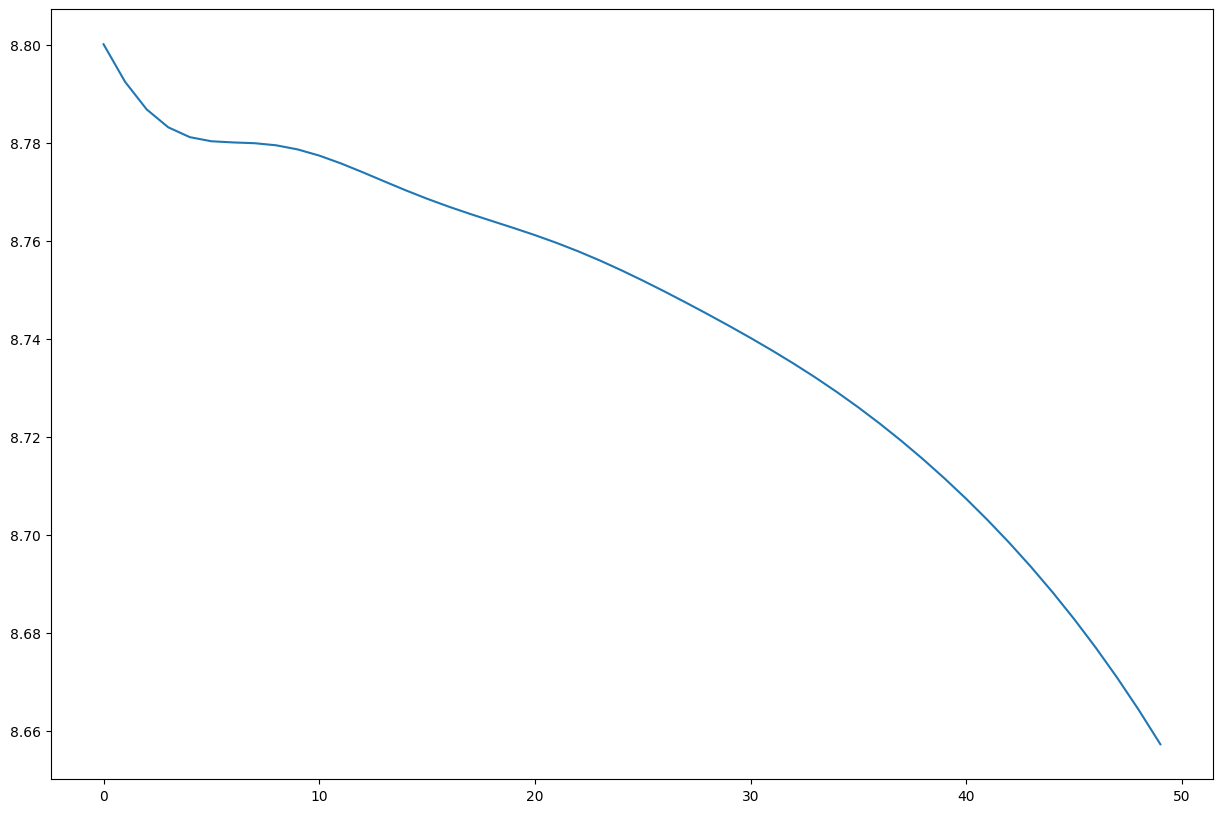

In [20]:
import torch.optim as optim
import torch.nn as nn


criterion = nn.MSELoss()  # Example: Mean Squared Error
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 50
train(net, dataset, optimizer, criterion, num_epochs)

In [ ]:
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import torch


max_radius = 5
num_basis = 10

irreps_input = o3.Irreps("1x1o")
irreps_output = o3.Irreps("1x0e")
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)


tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

# def conv(forces_in, positions):
#     edge_src, edge_dst = radius_graph(positions, max_radius, max_num_neighbors=len(positions) - 1)
#     edge_vec = positions[edge_dst] - positions[edge_src]

#     num_nodes = positions.shape[0]
#     num_neighbors = len(edge_src) / num_nodes
    
#     sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
#     emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_basis, basis='smooth_finite', cutoff=True).mul(num_basis**0.5)

#     tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)
#     print(num_basis)
#     print(tp.weight_numel)
#     fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)

#     return scatter(tp(forces_in[edge_src], sh, fc(emb)), edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors**0.5)

# result = conv(forces_in = graph_data.force_of_atoms, positions = graph_data.pos)

In [ ]:
total_loss.backward()


NameError: name 'total_loss' is not defined

In [ ]:
total_loss.backward()
optimizer.step()

tensor([[ 0.0049],
        [ 0.0192],
        [ 0.0049],
        [ 0.0192],
        [ 0.0177],
        [ 0.0241],
        [ 0.0256],
        [ 0.0113],
        [ 0.0384],
        [ 0.0241],
        [ 0.0113],
        [ 0.0113],
        [ 0.0192],
        [ 0.0256],
        [ 0.0384],
        [ 0.0113],
        [ 0.0241],
        [ 0.0177],
        [ 0.0192],
        [ 0.0049],
        [ 0.0049],
        [ 0.0192],
        [ 0.0192],
        [ 0.0113],
        [ 0.0113],
        [ 0.0241],
        [ 0.0161],
        [ 0.0712],
        [ 0.0326],
        [ 0.0633],
        [-0.0485],
        [-0.0626],
        [-0.0404],
        [-0.0320],
        [-0.0485],
        [ 0.0637],
        [ 0.0481],
        [ 0.0473],
        [ 0.0548],
        [-0.0164],
        [-0.0253],
        [-0.0399],
        [-0.0230],
        [-0.0163],
        [ 0.0069],
        [ 0.0081],
        [-0.0238],
        [ 0.0001],
        [ 0.0081],
        [ 0.0071],
        [ 0.0075],
        [ 0.0561],
        [-0.

In [ ]:
from sevenn.atom_graph_data import AtomGraphData

input_irreps = Irreps("1x1o")  
output_irreps = Irreps("1x0e")  # One scalar and three vectors

linear_layer = Linear(input_irreps, output_irreps)

graph_data = AtomGraphData.from_numpy_dict(data)
linear_layer(graph_data.force_of_atoms)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [ ]:
cutoff = 4

from ase.build import bulk, molecule
from ase.data import chemical_symbols
from sevenn.util import chemical_species_preprocess

_samples = {
    'bulk': bulk('NaCl', 'rocksalt', a=5.63),
    'mol': molecule('H2O'),
    'isolated': molecule('H'),
}
n_samples = len(_samples)
n_atoms_total = sum([len(at) for at in _samples.values()])


def get_model_config():
    config = {
        'cutoff': cutoff,
        'channel': 4,
        'radial_basis': {
            'radial_basis_name': 'bessel',
        },
        'cutoff_function': {'cutoff_function_name': 'poly_cut'},
        'interaction_type': 'nequip',
        'lmax': 2,
        'is_parity': True,
        'num_convolution_layer': 3,
        'weight_nn_hidden_neurons': [64, 64],
        'act_radial': 'silu',
        'act_scalar': {'e': 'silu', 'o': 'tanh'},
        'act_gate': {'e': 'silu', 'o': 'tanh'},
        'conv_denominator': 1.0,
        'train_denominator': False,
        'self_connection_type': 'nequip',
        'shift': -10.0,
        'scale': 10.0,
        'train_shift_scale': False,
        'irreps_manual': False,
        'lmax_edge': -1,
        'lmax_node': -1,
        'readout_as_fcn': False,
        'use_bias_in_linear': False,
        '_normalize_sph': True,
    }
    chems = set()
    for at in list(_samples.values()):
        chems.update(at.get_chemical_symbols())
    config.update(**chemical_species_preprocess(list(chems)))
    return config
config = get_model_config()

from sevenn.model_build import init_edge_embedding
edge_embedding = init_edge_embedding(config)

In [ ]:
from sevenn.nn.convolution import IrrepsConvolution

In [ ]:
irreps_filter = edge_embedding.spherical.irreps_out

In [ ]:
irreps_out = (
            util.infer_irreps_out(
                irreps_x,  # type: ignore
                irreps_filter,
                lmax_node,  # type: ignore
                parity_mode,
                fix_multiplicity=feature_multiplicity,
            )

In [ ]:
IrrepsConvolution(irreps_x = ,
        irreps_filter = ,
        irreps_out = )

In [ ]:
edge_embedding.spherical

SphericalEncoding(
  (sph): SphericalHarmonics()
)